In [1]:
import petsc4py
from petsc4py import PETSc

import underworld3 as uw
from underworld3.systems import Stokes
from underworld3 import function

import numpy as np
import sympy
import os
from datetime import datetime
import sys
import matplotlib.pyplot as plt
from underworld3.cython.petsc_discretisation import petsc_dm_find_labeled_points_local

In [2]:
u = uw.scaling.units
ndim = uw.scaling.non_dimensionalise
dim = uw.scaling.dimensionalise

# scaling 3: vel
H = 1000.  * u.kilometer
velocity     = 1e-9 * u.meter / u.second
#g    =   10.0 * u.meter / u.second**2  
#bodyforce    = 3300  * u.kilogram / u.metre**3 * g 
mu           = 1e21  * u.pascal * u.second

KL = H
Kt = KL / velocity
KM = mu * KL * Kt

scaling_coefficients                    = uw.scaling.get_coefficients()
scaling_coefficients["[length]"] = KL
scaling_coefficients["[time]"] = Kt
scaling_coefficients["[mass]"]= KM


In [3]:
D = ndim(1000*u.kilometer)
ratio =2
wavelength = D/ratio
k = 2.0 * np.pi / wavelength
mu0 = ndim(1e21  * u.pascal * u.second)
g = ndim(10.0 * u.meter / u.second**2 )
rho0 = ndim(1000  * u.kilogram / u.metre**3)
drho = rho0
F0 = ndim(50*u.kilometer)

yres = 50 
xmin, xmax = -1.5*D, 1.5*D
ymin, ymax = -D, 0
boxl = xmax-xmin
boxh = ymax-ymin
xres = int(boxl/boxh*yres)

x0 = np.linspace(xmin,xmax,xres+1)
y0 = F0*np.cos(k*x0)

def perturbation(x):
    y = F0 * np.cos(k*(x))
    return y

tau0 = 2*k*mu0/drho/g
# print(dim(tau0,u.kiloyear))
# print((ratio*4*np.pi*1e21/4500/3e6/10)/(365.25*24*60*60*1000))  #kiloyear
tmax = tau0*4

In [4]:
vel0 = dim(F0/tmax,u.centimeter/u.year)
print(vel0)

15.695462600364987 centimeter / year


In [5]:
case_bc = "freesurf"

#vel = ndim(25 *u.centimeter/u.year)
#vel = 0.
vel = ndim(2.*u.meter/u.year)

timeratio = 1/2
#timeratio = (1/2)**int(sys.argv[1])

render = True

tau0 =  ndim(10000*u.year)
dt_set    = tau0*timeratio
max_time  = tau0*10
save_every = 1


if save_every < 1:
    save_every = int(1)

use_fssa = True

if use_fssa:
    outputPath = "op_MovingTopoIsoEqual_FreeSurf" + "_yres{:n}_dt{:.1f}ka_Tmax{:.1f}ka_Vel{:.2f}_withFSSA_Algebraic_waveR{:n}/".format(yres,dim(dt_set,u.kiloyear).m,dim(max_time,u.kiloyear).m,dim(vel,u.centimeter/u.year).m,ratio)
else:
    outputPath = "op_MovingTopoIsoEqual_FreeSurf" + "_yres{:n}_dt{:.1f}ka_Tmax{:.1f}ka_Vel{:.2f}_noFSSA_Algebraic_waveR{:n}/".format(yres,dim(dt_set,u.kiloyear).m,dim(max_time,u.kiloyear).m,dim(vel,u.centimeter/u.year).m,ratio)
if uw.mpi.rank == 0:
    # delete previous model run
    if os.path.exists(outputPath):
        for i in os.listdir(outputPath):
            os.remove(outputPath+ i)
            
    ### create folder if not run before
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)

#print(ndim(max_time),ndim(dt_set),ndim(bodyforce))
print(outputPath)

op_MovingTopoIsoEqual_FreeSurf_yres50_dt5.0ka_Tmax100.0ka_Vel200.00_withFSSA_Algebraic_waveR2/


In [6]:
def plot_mesh(title,mesh,showFig=True):
    import numpy as np
    import pyvista as pv
    import vtk
    
    pv.global_theme.background = "white"
    pv.global_theme.window_size = [500, 500]
    pv.global_theme.jupyter_backend = "static"
    pv.global_theme.smooth_shading = True
    pv.global_theme.show_edges = True
    pv.global_theme.axes.show = True

    mesh.vtk("tmp_box_mesh.vtk")
    pvmesh = pv.read("tmp_box_mesh.vtk")
    pl = pv.Plotter()
    pl.add_mesh(pvmesh,'Black', 'wireframe')

    pl.add_title(title,font_size=11)
    if showFig:
        pl.show(cpos="xy")
    
    pl.screenshot(outputPath+title+".png",window_size=pv.global_theme.window_size,return_img=False) 
    pvmesh.clear_data() 
    pvmesh.clear_point_data()

In [7]:
mesh = uw.meshing.StructuredQuadBox(elementRes=(int(xres), int(yres)), minCoords=(xmin, ymin), maxCoords=(xmax, ymax))
init_mesh = uw.meshing.StructuredQuadBox(elementRes=(int(xres), int(yres)), minCoords=(xmin, ymin), maxCoords=(xmax, ymax))

botwall = petsc_dm_find_labeled_points_local(mesh.dm,"Bottom")
topwall = petsc_dm_find_labeled_points_local(mesh.dm,"Top")

# # dq2dq1
# v = uw.discretisation.MeshVariable("V", mesh, mesh.dim, degree=2)
# p = uw.discretisation.MeshVariable("P", mesh, 1, degree=1)

# q1dq0
v = uw.discretisation.MeshVariable("V", mesh, mesh.dim, degree=1,continuous=True)
p = uw.discretisation.MeshVariable("P", mesh, 1, degree=0,continuous=False)

timeField     = uw.discretisation.MeshVariable("time", mesh, 1, degree=1)

density_fn =rho0
visc_fn =mu0
ND_gravity = ndim(g)

Tmesh = uw.discretisation.MeshVariable("Tmesh", init_mesh, 1, degree=1)
Bmesh = uw.discretisation.MeshVariable("Bmesh", init_mesh, 1, degree=1)

mesh_solver = uw.systems.Poisson(init_mesh, u_Field=Tmesh, solver_name="FreeSurf_solver")
mesh_solver.constitutive_model = uw.constitutive_models.DiffusionModel
mesh_solver.constitutive_model.Parameters.diffusivity = 1. 
mesh_solver.f = 0.0
mesh_solver.add_dirichlet_bc((Bmesh.sym[0],), "Top")
mesh_solver.add_dirichlet_bc((Bmesh.sym[0],), "Bottom")

x_ = init_mesh.data[topwall,0]
y_ = perturbation(x_)
y_[x_> wavelength/4] = 0
y_[x_< -wavelength/4] = 0

with init_mesh.access(Bmesh):
    Bmesh.data[topwall, 0] = y_
    Bmesh.data[botwall, 0] = init_mesh.data[botwall,-1]
mesh_solver.solve()

def update_mesh():
    with init_mesh.access():
        new_mesh_coords = init_mesh.data
        new_mesh_coords[:,-1] = Tmesh.data[:,0]
    return new_mesh_coords
new_mesh_coords = update_mesh()
mesh.deform_mesh(new_mesh_coords)

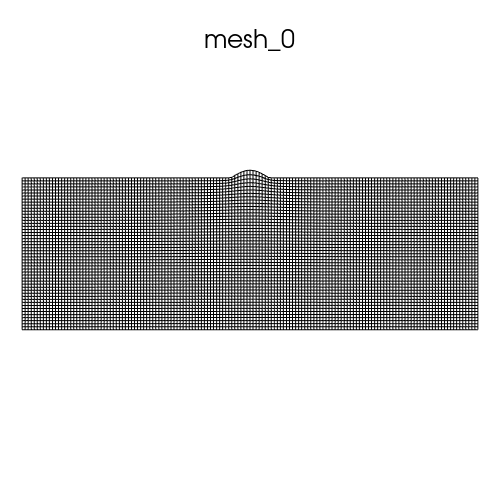

In [8]:
plot_mesh('mesh_0',mesh,showFig=True)

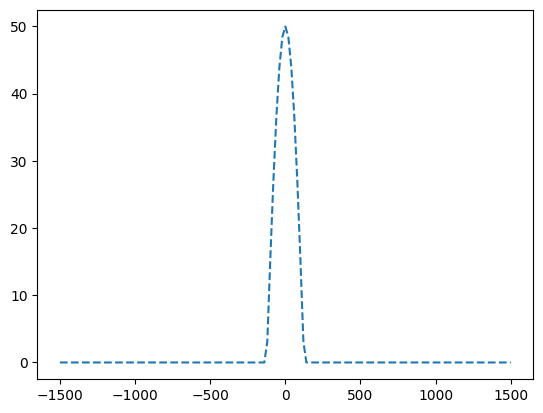

In [9]:
coords = mesh.data[topwall]

xx2 = coords[:,0][np.argsort(coords[:,0])]*KL.m 
yy2 = coords[:,1][np.argsort(coords[:,0])]*KL.m 
plt.plot(xx2,yy2,'--')

In [10]:
# stokes = uw.systems.Stokes(mesh, velocityField=v, pressureField=p)
# stokes.constitutive_model = uw.constitutive_models.ViscousFlowModel
# #stokes.bodyforce = sympy.Matrix([0, -1 * ND_gravity * density_fn])
# stokes.bodyforce = sympy.Matrix([0, 0.])
# stokes.constitutive_model.Parameters.shear_viscosity_0 = visc_fn
# stokes.saddle_preconditioner = 1.0 / stokes.constitutive_model.Parameters.shear_viscosity_0
# stokes.add_essential_bc((vel,0.), "Left")
# stokes.add_essential_bc((vel,0.), "Right")
# stokes.add_essential_bc((None,0.0), "Bottom")

# if uw.mpi.size == 1:
#     stokes.petsc_options['pc_type'] = 'lu'

# stokes.tolerance = 1.0e-6
# stokes.petsc_options["ksp_rtol"] = 1.0e-6
# stokes.petsc_options["ksp_atol"] = 1.0e-6
# stokes.petsc_options["snes_converged_reason"] = None
# stokes.petsc_options["snes_monitor_short"] = None

# if use_fssa:
#     #delta_t = uw.function.expression(R"\delta t", sympy.Min(0.5 * stokes.estimate_dt(),sympy.sympify(dt_set)), "Timestep")
#     delta_t = dt_set
#     theta = 0.5*density_fn*ND_gravity*delta_t
#     FSSA_traction = theta*mesh.Gamma.dot(v.sym) * mesh.Gamma
#     stokes.add_natural_bc(FSSA_traction, "Top")

In [11]:
def _adjust_time_units(val):
    """ Adjust the units used depending on the value """
    if isinstance(val, u.Quantity):
        mag = val.to(u.years).magnitude
    else:
        val = dim(val, u.years)
        mag = val.magnitude
    exponent = int("{0:.3E}".format(mag).split("E")[-1])

    if exponent >= 9:
        units = u.gigayear
    elif exponent >= 6:
        units = u.megayear
    elif exponent >= 3:
        units = u.kiloyears
    elif exponent >= 0:
        units = u.years
    elif exponent > -3:
        units = u.days
    elif exponent > -5:
        units = u.hours
    elif exponent > -7:
        units = u.minutes
    else:
        units = u.seconds
    return val.to(units)

In [12]:
from scipy.interpolate import interp1d
from scipy.interpolate import CloughTocher2DInterpolator
from scipy.interpolate import pchip_interpolate


class FreeSurfaceProcessor(object): 
    def __init__(self,mesh,v,dt):
        """
        Parameters
        ----------
        _init_mesh : the original mesh
        mesh : the updating model mesh
        vel : the velocity field of the model
        dt : dt for advecting the surface
        """
        if mesh.dim == 2:
            self.init_mesh = uw.meshing.StructuredQuadBox(elementRes=(int(xres), int(yres)), minCoords=(xmin, ymin), maxCoords=(xmax, ymax))
        else:
            self.init_mesh = uw.meshing.StructuredQuadBox(elementRes=(int(xres), int(yres),int(zres)), minCoords=(xmin, ymin, zmin), maxCoords=(xmax, ymax, zmax))
        self.Tmesh = uw.discretisation.MeshVariable("Tmesh", self.init_mesh, 1, degree=1)
        self.Bmesh = uw.discretisation.MeshVariable("Bmesh", self.init_mesh, 1, degree=1)
        self.mesh_solver = uw.systems.Poisson(self.init_mesh , u_Field=self.Tmesh, solver_name="FreeSurf_solver")
        self.mesh_solver.constitutive_model = uw.constitutive_models.DiffusionModel
        self.mesh_solver.constitutive_model.Parameters.diffusivity = 1. 
        self.mesh_solver.f = 0.0
        self.mesh_solver.add_dirichlet_bc((self.Bmesh.sym[0],), "Top")
        self.mesh_solver.add_dirichlet_bc((self.Bmesh.sym[0],), "Bottom")

        self.mesh = mesh 
        self.v = v
        self._dt   = dt

        self.top = petsc_dm_find_labeled_points_local(self.mesh.dm,"Top")
        self.bottom = petsc_dm_find_labeled_points_local(self.mesh.dm,"Bottom")

    def _solve_sle(self):
        self.mesh_solver.solve()
     
    def _advect_surface(self):
        if self.top.size > 0:
            if self.mesh.dim == 2:
                coords = self.mesh.data[self.top]
                x = coords[:,0]
                y = coords[:,-1]
                vx = uw.function.evalf(self.v.sym[0], coords)
                vy = uw.function.evalf(self.v.sym[1], coords)
                
                # Advect top surface
                x2 = x + vx * self._dt
                y2 = y + vy * self._dt
        
                # Spline top surface
                #fx = pchip_interpolate(x2,y2,x)
                f = interp1d(x2, y2, kind='cubic', fill_value='extrapolate')
    
                with self.init_mesh.access(self.Bmesh):
                    self.Bmesh.data[self.bottom, 0] = self.mesh.data[self.bottom, -1]
                    self.Bmesh.data[self.top, 0] = f(x)      
             # TO DO : with mpi
             # need reordering y according x then interp?
            else:
                coords = self.mesh.data[self.top]
                x = coords[:,0]
                y = coords[:,1]
                z = coords[:,-1]
                vx = uw.function.evalf(self.v.sym[0], coords)
                vy = uw.function.evalf(self.v.sym[1], coords)
                vz = uw.function.evalf(self.v.sym[2], coords)
                
                # Advect top surface
                x2 = x + vx * self._dt
                y2 = y + vy * self._dt
                z2 = z + vz * self._dt
        
                # Spline top surface
                f = CloughTocher2DInterpolator((x2, y2), z2)
    
                with self.init_mesh.access(self.Bmesh):
                    self.Bmesh.data[self.bottom, 0] = self.mesh.data[self.bottom, -1]
                    self.Bmesh.data[self.top, 0] = f((x,y)) 
        uw.mpi.barrier()
        #self.Bmesh.syncronise()
        self.init_mesh.update_lvec()
        #a_global = self.init_mesh.dm.getGlobalVec()
        #self.init_mesh.dm.localToGlobal(self.init_mesh.lvec, a_global)
         
    def _update_mesh(self):
        with self.init_mesh.access():
            new_mesh_coords = self.init_mesh.data
            new_mesh_coords[:,-1] = self.Tmesh.data[:,0]   
        #mesh.deform_mesh(new_mesh_coords)
        return new_mesh_coords
        
    
    def solve(self):
        self._advect_surface()
        self._solve_sle()
        new_mesh_coords = self._update_mesh()
        return new_mesh_coords

In [13]:
step      = 0
max_steps = 2
time      = 0
dt        = 0

while time < max_time:
#while step < max_steps:
    if uw.mpi.rank == 0:
        string = """Step: {0:5d} Model Time: {1:6.1f} dt: {2:6.1f} ({3})\n""".format(
        step, _adjust_time_units(time),
        _adjust_time_units(dt),
        datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
        sys.stdout.write(string)
        sys.stdout.flush()
    
    #stokes.solve(zero_init_guess=False)

    with mesh.access(v):
        v.data[:,0] = vel
        v.data[:,1] = 0

    if step%save_every ==0:
        if uw.mpi.rank == 0:
            print(f'\nSave data:')
        with mesh.access(timeField):
            timeField.data[:,0] = time
        mesh.petsc_save_checkpoint(meshVars=[v, p, timeField], index=step, outputPath=outputPath)

    # dt_solver = stokes.estimate_dt()
    # dt = min(dt_solver,dt_set)
    dt = dt_set
    
    freesuface = FreeSurfaceProcessor(mesh,v,dt)
    new_mesh_coords=freesuface.solve()
    mesh.deform_mesh(new_mesh_coords)

    step += 1
    time += dt

Step:     0 Model Time: 0.0 year dt: 0.0 year (2024-07-01 16:25:16)

Save data:
Step:     1 Model Time: 5.0 kiloyear dt: 5.0 kiloyear (2024-07-01 16:25:19)

Save data:
Step:     2 Model Time: 10.0 kiloyear dt: 5.0 kiloyear (2024-07-01 16:25:22)

Save data:
Step:     3 Model Time: 15.0 kiloyear dt: 5.0 kiloyear (2024-07-01 16:25:26)

Save data:
Step:     4 Model Time: 20.0 kiloyear dt: 5.0 kiloyear (2024-07-01 16:25:29)

Save data:
Step:     5 Model Time: 25.0 kiloyear dt: 5.0 kiloyear (2024-07-01 16:25:33)

Save data:
Step:     6 Model Time: 30.0 kiloyear dt: 5.0 kiloyear (2024-07-01 16:25:37)

Save data:
Step:     7 Model Time: 35.0 kiloyear dt: 5.0 kiloyear (2024-07-01 16:25:40)

Save data:
Step:     8 Model Time: 40.0 kiloyear dt: 5.0 kiloyear (2024-07-01 16:25:44)

Save data:
Step:     9 Model Time: 45.0 kiloyear dt: 5.0 kiloyear (2024-07-01 16:25:48)

Save data:
Step:    10 Model Time: 50.0 kiloyear dt: 5.0 kiloyear (2024-07-01 16:25:52)

Save data:
Step:    11 Model Time: 55.0 ki

In [14]:
print('Done')

Done


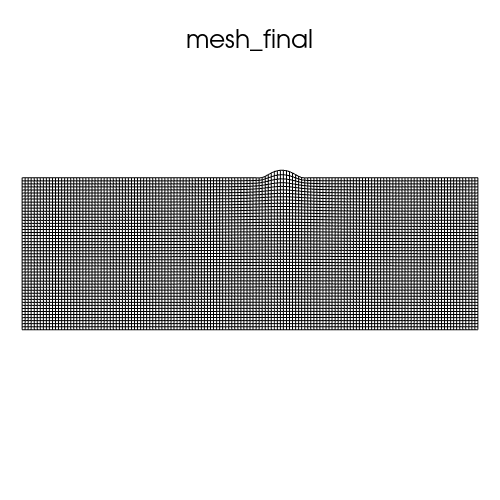

In [15]:
plot_mesh('mesh_final',mesh,showFig=True)